In [1]:
# Import python libraries
#
import importlib
import pickle
import os
import torch

# Go one directory back, because all imports are done
# relative to the root of the project.
#
project_root = '..'
if 'change_directory_to_root' not in globals():
    change_directory_to_root = True
    os.chdir(project_root)

# Imports own modules.
#
import scripts.Visualization as Visualization
import scripts.ModelTrainer as ModelTrainer
import scripts.Utils as utils
import scripts.Simulation_config as Simulation_config
from scripts.Simulation_config import *
import scripts.Model as model
import scripts.ModelAdapter as ModelAdapter


/home/molu/miniconda3/envs/xlstm/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
No CUDA runtime is found, using CUDA_HOME='/home/molu/miniconda3/envs/xlstm'


In [25]:
importlib.reload(model)
importlib.reload(Simulation_config)
importlib.reload(utils)

# Print the sumarized simulation results
#
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')
result_dict


defaultdict(<function scripts.Utils.Evaluate_Models.print_results.<locals>.<lambda>()>,
            {'error': defaultdict(<function scripts.Utils.Evaluate_Models.print_results.<locals>.<lambda>.<locals>.<lambda>()>,
                         {0: defaultdict(<function scripts.Utils.Evaluate_Models.print_results.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>()>,
                                      {'SyntheticLoadProfile': '33.24',
                                       'KNN': '16.89',
                                       'PersistencePrediction': '14.27',
                                       'xLSTM': '12.63',
                                       'LSTM': '12.67',
                                       'Transformer': '13.18'}),
                          1: defaultdict(<function scripts.Utils.Evaluate_Models.print_results.<locals>.<lambda>.<locals>.<lambda>.<locals>.<lambda>()>,
                                      {'SyntheticLoadProfile': '33.24',
                            

In [5]:
# Store specific predictions, for the paper 'use case' section.
#

importlib.reload(model)
importlib.reload(utils)
importlib.reload(ModelTrainer)

# Define a specific configuration
#
myConfig = Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._37_HOUSEHOLDS, 
                NrOfComunities._20, TrainingHistory._15_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT)

modelTrainer = ModelTrainer.ModelTrainer()
loadProfiles, weatherData, public_holidays_timestamps = modelTrainer.load_data(myConfig)
modelAdapter = ModelAdapter.ModelAdapter(public_holidays_timestamps, 
                                            train_size = myConfig.trainingHistory,
                                            test_size = modelTrainer.test_set_size_days, 
                                            prediction_history = myConfig.modelInputHistory,
                                            )
community_id = 0  # chose one of many energy communites
X, Y = modelAdapter.transformData(loadProfiles[community_id], weatherData)
path_to_trained_parameters = 'scripts/outputs/all_trained_models_20241107_0520.pth'
num_of_features = X['train'].shape[2]
P_el_predicted = modelAdapter.deNormalizeY(Y['test']).flatten().unsqueeze(0)

# Store the predicted power profiles
#
for model_type in Simulation_config.UsedModels.ALL:
    test_profile = f"scripts/outputs/file_{community_id}.pkl"
    my_Model = utils.Deserialize.get_trained_model(path_to_trained_parameters, model_type, test_profile, myConfig, num_of_features)
    Y_pred = torch.Tensor(modelAdapter.deNormalizeY(my_Model.predict(X['test'], Y['test'])).flatten())
    P_el_predicted = torch.cat([P_el_predicted, Y_pred.unsqueeze(0)], dim=0)    

startdate = modelAdapter.getStartDateFromIndex('test', 0)
file_path = "scripts/outputs/example_predictions.pkl"
with open(file_path, 'wb') as file:
    pickle.dump((P_el_predicted, startdate), file)

print(P_el_predicted.shape)
print(startdate)


torch.Size([7, 3144])
2013-10-20 00:00:00+00:00


In [32]:
list(pd.DataFrame(result_dict['error']).loc['xLSTM', 3:6])



['47.61', '23.99', '9.26', '24.74']

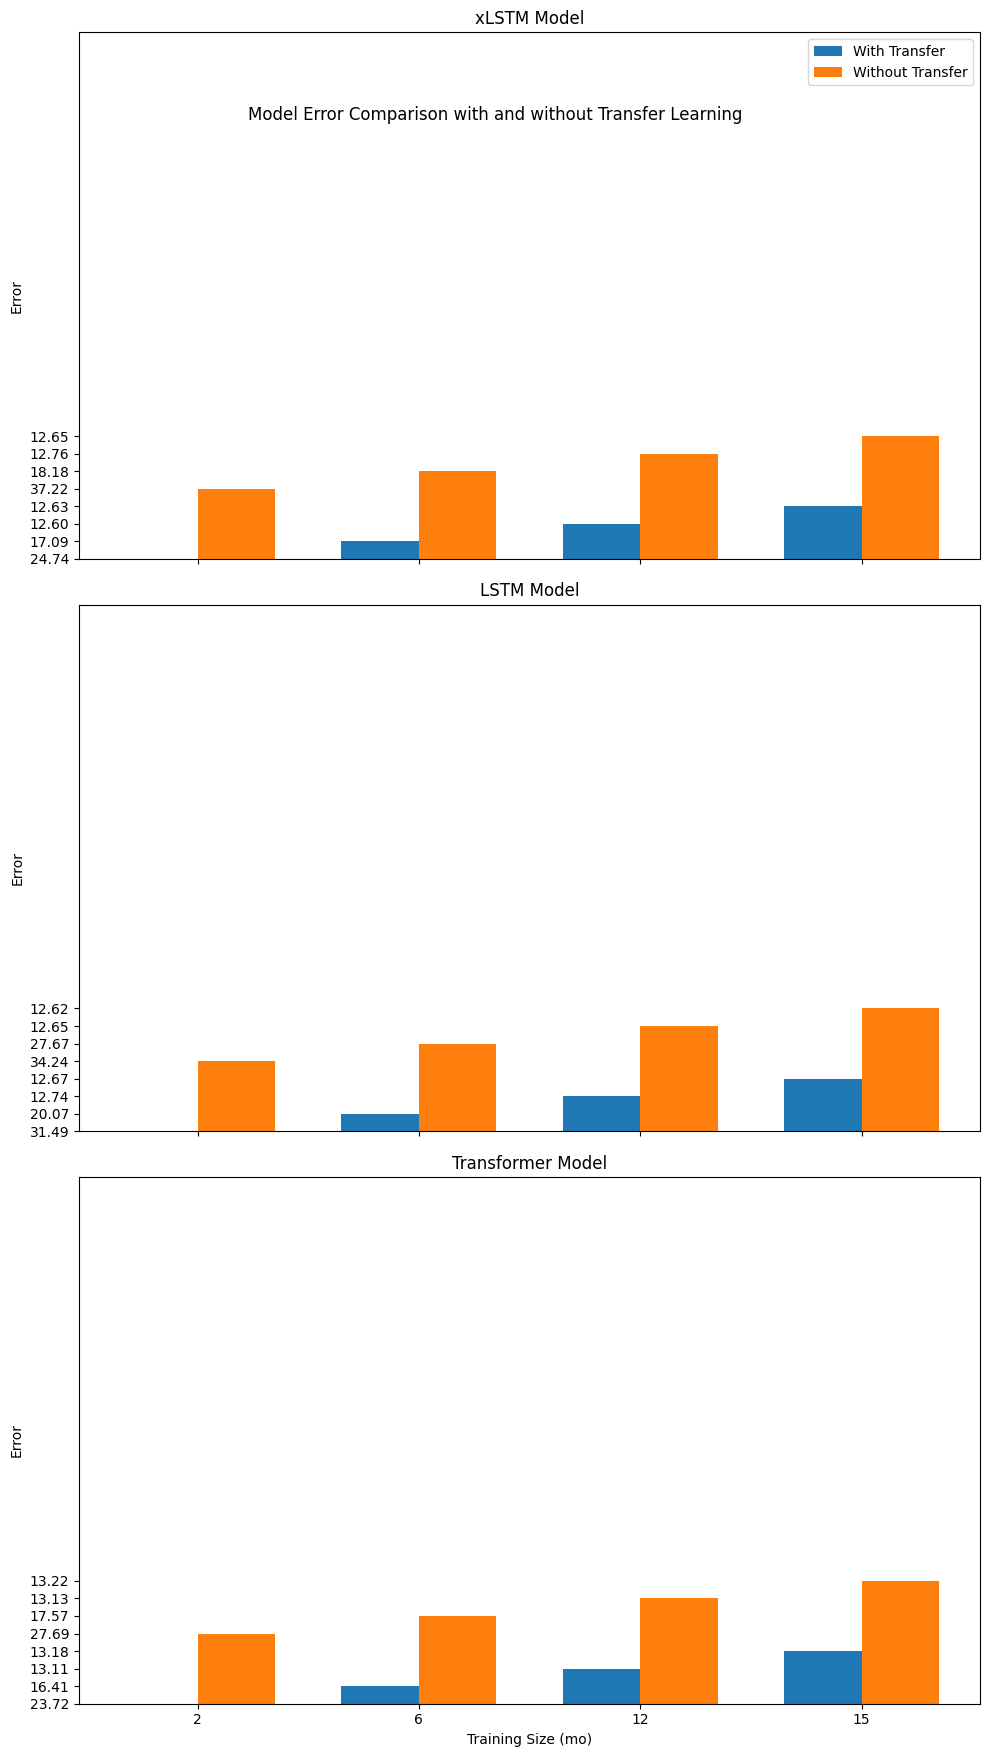

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def get_selected_list(metric, model, configs):
    return pd.DataFrame(result_dict[metric]).loc[model, configs].tolist()

# Define training sizes
training_sizes = ['2', '6', '12', '15']

# Create DataFrame for data with transfer
configs = [6, 7, 8, 0]
df_with_transfer = pd.DataFrame({
    'Training Size (mo)': training_sizes,
    'xLSTM': get_selected_list('error', 'xLSTM', configs),
    'xLSTM deviation': get_selected_list('deviation', 'xLSTM', configs),
    'LSTM': get_selected_list('error', 'LSTM', configs),
    'LSTM deviation': get_selected_list('deviation', 'LSTM', configs),
    'Transformer': get_selected_list('error', 'Transformer', configs),
    'Transformer deviation': get_selected_list('deviation', 'Transformer', configs)
})

# Create DataFrame for data without transfer
configs = [16, 17, 18, 10]
df_without_transfer = pd.DataFrame({
    'Training Size (mo)': training_sizes,
    'xLSTM': get_selected_list('error', 'xLSTM', configs),
    'xLSTM deviation': get_selected_list('deviation', 'xLSTM', configs),
    'LSTM': get_selected_list('error', 'LSTM', configs),
    'LSTM deviation': get_selected_list('deviation', 'LSTM', configs),
    'Transformer': get_selected_list('error', 'Transformer', configs),
    'Transformer deviation': get_selected_list('deviation', 'Transformer', configs)
})


# Plotting
models = ['xLSTM', 'LSTM', 'Transformer']
x = np.arange(len(training_sizes))  # the label locations
width = 0.35  # the width of the bars

fig, axes = plt.subplots(3, 1, figsize=(10, 18), sharex=True)

for idx, model in enumerate(models):
    ax = axes[idx]
    
    # Bars for data with and without transfer
    # ax.bar(x - width/2, df_with_transfer[model], width, label='With Transfer', yerr=df_with_transfer[f'{model} deviation'], capsize=5)
    # ax.bar(x + width/2, df_without_transfer[model], width, label='Without Transfer', yerr=df_without_transfer[f'{model} deviation'], capsize=5)

    ax.bar(x - width/2, df_with_transfer[model], width, label='With Transfer')
    ax.bar(x + width/2, df_without_transfer[model], width, label='Without Transfer')
    
    # Set y-axis limit
    ax.set_ylim(0, 30)  # Add a little margin at the top

    # Labels and title
    ax.set_ylabel('Error')
    ax.set_title(f"{model} Model")
    ax.set_xticks(x)
    ax.set_xticklabels(training_sizes)

# Set common properties
axes[-1].set_xlabel('Training Size (mo)')
fig.suptitle('Model Error Comparison with and without Transfer Learning', y=0.92)
axes[0].legend(loc='upper right')

plt.tight_layout()
plt.show()


In [92]:
df_with_transfer

,Training Size (mo),xLSTM,xLSTM deviation,LSTM,LSTM deviation,Transformer,Transformer deviation
0,2,24.74,6.82,31.49,6.34,23.72,5.72
1,6,17.09,1.10,20.07,1.50,16.41,1.20
2,12,12.60,0.99,12.74,0.91,13.11,0.99
3,15,12.63,0.92,12.67,1.02,13.18,0.89


In [76]:
df_with_transfer['LSTM deviation']

0    6.34
1    1.50
2    0.91
3    1.02
Name: LSTM deviation, dtype: object